In [1]:
!pip install scikit-learn pandas


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import pickle


In [24]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from time import sleep

# Define arXiv categories and labels
categories = {
    "cs.AI": "Artificial Intelligence",
    "cs.LG": "Machine Learning",
    "physics.gen-ph": "General Physics",
    "math.PR": "Probability",
    "stat.ML": "Statistical ML",
    "q-bio.NC": "Neuroscience",
    "econ.EM": "Econometrics"
}

# Parameters
docs_per_category = 1000
batch_size = 100
base_url = "http://export.arxiv.org/api/query"
all_data = []

# Fetch documents
for cat, label in categories.items():
    print(f"\n🔍 Fetching {label} papers...")
    for start in range(0, docs_per_category, batch_size):
        params = {
            "search_query": f"cat:{cat}",
            "start": start,
            "max_results": batch_size,
            "sortBy": "submittedDate",
            "sortOrder": "descending"
        }

        try:
            response = requests.get(base_url, params=params, timeout=15)
            response.raise_for_status()
        except Exception as e:
            print(f"⚠️ Request failed at {cat}, start {start}: {e}")
            continue

        root = ET.fromstring(response.content)

        for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
            title = entry.find("{http://www.w3.org/2005/Atom}title").text.strip()
            summary = entry.find("{http://www.w3.org/2005/Atom}summary").text.strip()
            authors = [a.find("{http://www.w3.org/2005/Atom}name").text for a in entry.findall("{http://www.w3.org/2005/Atom}author")]
            authors_str = ", ".join(authors)

            # Extract PDF link and size
            pdf_url = None
            pdf_size = 0
            for link in entry.findall("{http://www.w3.org/2005/Atom}link"):
                if link.attrib.get("title") == "pdf":
                    pdf_url = link.attrib["href"]
                    try:
                        head = requests.head(pdf_url, allow_redirects=True, timeout=10)
                        pdf_size = int(head.headers.get("Content-Length", 0))
                    except:
                        pdf_size = 0
                    break

            all_data.append({
                "title": title,
                "abstract": summary,
                "authors": authors_str,
                "category": label,
                "pdf_url": pdf_url,
                "pdf_size_bytes": pdf_size,
                "pdf_size_MB": round(pdf_size / (1024 ** 2), 2)
            })

        print(f"✅ Retrieved {start + batch_size} / {docs_per_category} for {label}")
        sleep(3)  # Respect API rate limits

# Save to CSV
df = pd.DataFrame(all_data)
df.to_csv("arxiv_dataset.csv", index=False)

# Print summary
print(f"\n📚 Total documents collected: {len(df)}")
print(f"📦 Total estimated PDF size: {df['pdf_size_MB'].sum():.2f} MB")
print("📁 Saved to arxiv_dataset.csv")



🔍 Fetching Artificial Intelligence papers...
✅ Retrieved 100 / 1000 for Artificial Intelligence
✅ Retrieved 200 / 1000 for Artificial Intelligence
✅ Retrieved 300 / 1000 for Artificial Intelligence
✅ Retrieved 400 / 1000 for Artificial Intelligence
✅ Retrieved 500 / 1000 for Artificial Intelligence
✅ Retrieved 600 / 1000 for Artificial Intelligence
✅ Retrieved 700 / 1000 for Artificial Intelligence
✅ Retrieved 800 / 1000 for Artificial Intelligence
✅ Retrieved 900 / 1000 for Artificial Intelligence
✅ Retrieved 1000 / 1000 for Artificial Intelligence

🔍 Fetching Machine Learning papers...
✅ Retrieved 100 / 1000 for Machine Learning
✅ Retrieved 200 / 1000 for Machine Learning
✅ Retrieved 300 / 1000 for Machine Learning
✅ Retrieved 400 / 1000 for Machine Learning
✅ Retrieved 500 / 1000 for Machine Learning
✅ Retrieved 600 / 1000 for Machine Learning
✅ Retrieved 700 / 1000 for Machine Learning
✅ Retrieved 800 / 1000 for Machine Learning
✅ Retrieved 900 / 1000 for Machine Learning
✅ Retrie

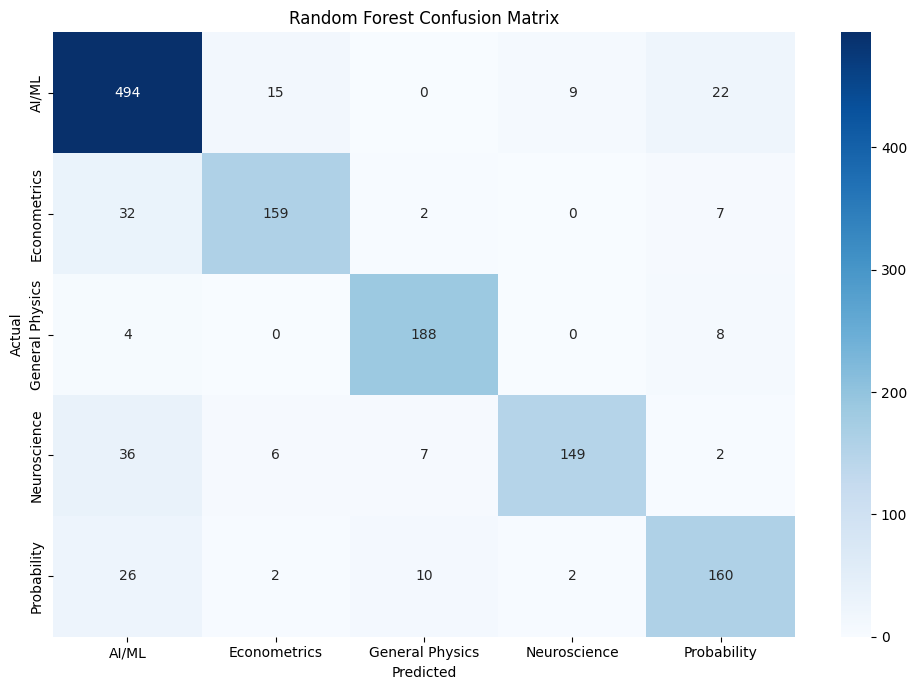

==== Random Forest Classifier Results ====
Training time: 56.04 seconds
Test F1 Score (Weighted): 0.8571
Cross-Validation F1 Score (Weighted, 5-fold): 0.8620

Detailed Classification Report:


,precision,recall,f1-score,support
AI/ML,0.83,0.91,0.87,540.00
Econometrics,0.87,0.80,0.83,200.00
General Physics,0.91,0.94,0.92,200.00
Neuroscience,0.93,0.74,0.83,200.00
Probability,0.80,0.80,0.80,200.00
accuracy,0.86,0.86,0.86,0.86
macro avg,0.87,0.84,0.85,1340.00
weighted avg,0.86,0.86,0.86,1340.00


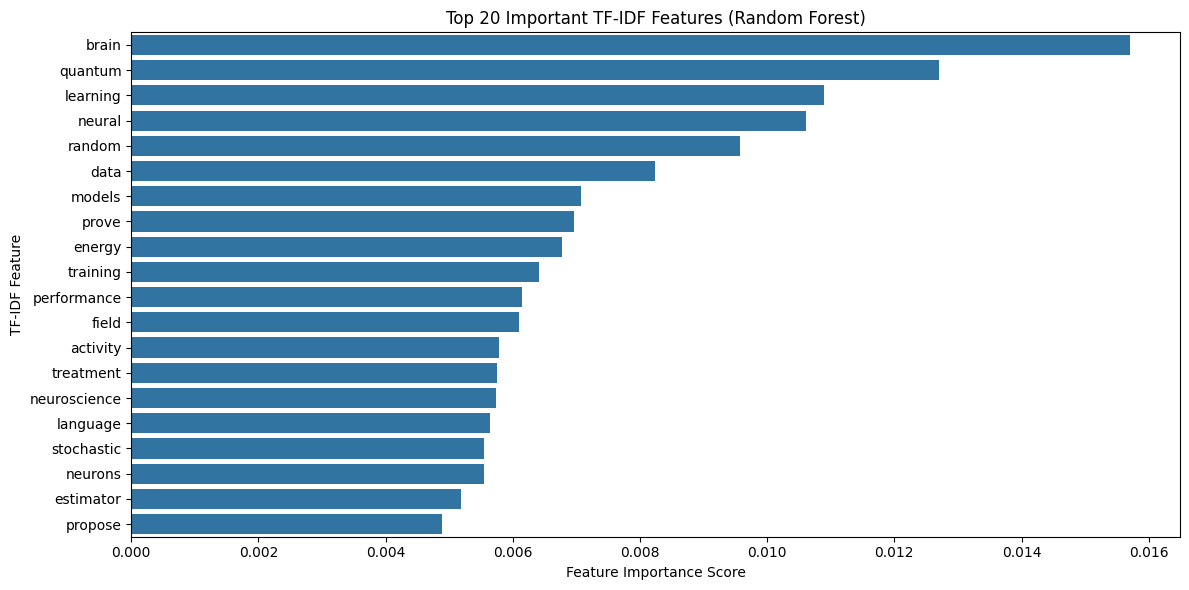

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Load and preprocess data
df = pd.read_csv("arxiv_dataset.csv")
df.dropna(subset=["abstract", "category"], inplace=True)

# Merge ML-related categories into one
df["category"] = df["category"].replace({
    'Artificial Intelligence': 'AI/ML',
    'Machine Learning': 'AI/ML',
    'Statistical ML': 'AI/ML'
})

# Encode category labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["category"])
class_names = label_encoder.classes_

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, stop_words="english")
X = vectorizer.fit_transform(df["abstract"])

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train Random Forest and measure time
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

training_time = time.time() - start_time

# Predict and evaluate
y_pred = rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average="weighted")
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Cross-validation (Stratified K-Fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X, y, cv=cv, scoring="f1_weighted")

# Display metrics
print("==== Random Forest Classifier Results ====")
print(f"Training time: {training_time:.2f} seconds")
print(f"Test F1 Score (Weighted): {f1:.4f}")
print(f"Cross-Validation F1 Score (Weighted, 5-fold): {cv_scores.mean():.4f}")
print("\nDetailed Classification Report:")
display(report_df.round(2))

# Feature importance (top 20)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]
top_features = [vectorizer.get_feature_names_out()[i] for i in indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=top_features)
plt.title("Top 20 Important TF-IDF Features (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.ylabel("TF-IDF Feature")
plt.tight_layout()
plt.show()


In [26]:
sorted_df = df.sort_values(by='title')
print(sorted_df[['title', 'category']].head(10))

                                                  title         category
5589  "Efficient Complexity": a Constrained Optimiza...     Neuroscience
418   "I Hadn't Thought About That": Creators of Hum...            AI/ML
647   "I Said Things I Needed to Hear Myself": Peer ...            AI/ML
648   "Is This Really a Human Peer Supporter?": Misa...            AI/ML
1709  "Quantum supremacy" challenged. Instantaneous ...  General Physics
2383  "Quantum supremacy" revisited: Low-complexity,...  General Physics
1393  "What are my options?": Explaining RL Agents w...            AI/ML
5606  "What" x "When" working memory representations...     Neuroscience
4074  "Who experiences large model decay and why?" A...            AI/ML
660   $(RSA)^2$: A Rhetorical-Strategy-Aware Rationa...            AI/ML


In [27]:
def search_documents(df, query):
    query = query.lower()
    matches = df[df['abstract'].str.lower().str.contains(query)]
    print(f"Found {len(matches)} documents containing '{query}'")

    # Highlight match in abstract (CLI example)
    for _, row in matches.iterrows():
        highlighted = row['abstract'].replace(query, f"\033[1;31m{query}\033[0m")
        print(f"\nTitle: {row['title']}\nAbstract: {highlighted}\n")

search_documents(df, "quantum")


Found 465 documents containing 'quantum'

Title: A Two-stage Optimization Method for Wide-range Single-electron Quantum
  Magnetic Sensing
Abstract: Quantum magnetic sensing based on spin systems has emerged as a new paradigm
for detecting ultra-weak magnetic fields with unprecedented sensitivity,
revitalizing applications in navigation, geo-localization, biology, and beyond.
At the heart of quantum magnetic sensing, from the protocol perspective, lies
the design of optimal sensing parameters to manifest and then estimate the
underlying signals of interest (SoI). Existing studies on this front mainly
rely on adaptive algorithms based on black-box AI models or formula-driven
principled searches. However, when the SoI spans a wide range and the quantum
sensor has physical constraints, these methods may fail to converge efficiently
or optimally, resulting in prolonged interrogation times and reduced sensing
accuracy. In this work, we report the design of a new protocol using a
two-stage o

In [28]:
def print_full_statistics(df, downloaded_files, training_time, f1_score_value, cv_scores):
    print("\n📊 Dataset & Performance Statistics")
    print(f"- Total number of documents in dataset: {len(df)}")
    print(f"- Number of unique categories: {df['category'].nunique()}")
    print(f"- Number of unique titles: {df['title'].nunique()}")

    if downloaded_files:
        total_pdf_size = sum(Path(f[0]).stat().st_size for f in downloaded_files) / (1024 ** 2)
        print(f"- Size of downloaded sample PDFs: {total_pdf_size:.2f} MB")
        print(f"- Number of downloaded PDFs: {len(downloaded_files)}")
    else:
        print("- No PDFs were downloaded.")

    print(f"- Random Forest training time: {training_time:.2f} seconds")
    print(f"- Test F1 Score (Weighted): {f1_score_value:.4f}")
    print(f"- Cross-Validation F1 Score (5-fold, Weighted): {cv_scores.mean():.4f}")

print_full_statistics(df, pdf_files, training_time, f1, cv_scores)



📊 Dataset & Performance Statistics
- Total number of documents in dataset: 6700
- Number of unique categories: 5
- Number of unique titles: 6205
- Size of downloaded sample PDFs: 78.03 MB
- Number of downloaded PDFs: 20
- Random Forest training time: 56.04 seconds
- Test F1 Score (Weighted): 0.8571
- Cross-Validation F1 Score (5-fold, Weighted): 0.8620


In [29]:
!pip install PyMuPDF

In [30]:
import os
import requests
import fitz  # PyMuPDF
import pandas as pd
from pathlib import Path
from typing import List

# Set up directory to save PDFs
pdf_dir = Path("downloaded_pdfs")
pdf_dir.mkdir(exist_ok=True)

def download_pdfs(df, limit=20):
    """Download PDFs from a random sample of the DataFrame"""
    saved_files = []
    sampled_df = df.sample(n=min(limit, len(df)), random_state=42)

    for idx, row in sampled_df.iterrows():
        if row['pdf_url']:
            pdf_path = pdf_dir / f"doc_{idx}.pdf"
            try:
                response = requests.get(row['pdf_url'], timeout=10)
                if response.status_code == 200:
                    with open(pdf_path, 'wb') as f:
                        f.write(response.content)
                    saved_files.append((pdf_path, row['title']))
                    print(f"Downloaded: {pdf_path}")
                else:
                    print(f"Failed to download {row['pdf_url']}")
            except Exception as e:
                print(f"Error downloading {row['pdf_url']}: {e}")
        if len(saved_files) >= limit:
            break
    return saved_files

def extract_text_from_pdf(pdf_path: Path) -> str:
    """Extract full text from a PDF file using PyMuPDF"""
    text = ""
    try:
        doc = fitz.open(pdf_path)
        for page in doc:
            text += page.get_text("text")
        doc.close()
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text

def search_keyword_in_pdfs(pdf_files: List[tuple], keyword: str):
    """Search for a keyword in a list of PDFs and highlight matches"""
    keyword = keyword.lower()
    found_any = False

    for pdf_path, title in pdf_files:
        text = extract_text_from_pdf(pdf_path)
        if keyword in text.lower():
            found_any = True
            print(f"\n🔍 Found '{keyword}' in: {title} ({pdf_path.name})")
            start = text.lower().find(keyword)
            snippet = text[max(0, start - 50):start + 50].replace(
                keyword, f"\033[1;31m{keyword}\033[0m"
            )
            print(f"...{snippet}...")
        else:
            print(f"'{keyword}' not found in this document.")

    if not found_any:
        print(f"\n❌ No documents contained the keyword '{keyword}'.")

# === Example usage ===
df = pd.read_csv("arxiv_dataset.csv")
df.dropna(subset=["pdf_url", "title"], inplace=True)

# Download random 10 PDFs
pdf_files = download_pdfs(df, limit=20)

# Search for a keyword
search_keyword_in_pdfs(pdf_files, keyword="quantum")


Downloaded: downloaded_pdfs/doc_4201.pdf
Downloaded: downloaded_pdfs/doc_2229.pdf
Downloaded: downloaded_pdfs/doc_5556.pdf
Downloaded: downloaded_pdfs/doc_3080.pdf
Downloaded: downloaded_pdfs/doc_263.pdf
Downloaded: downloaded_pdfs/doc_696.pdf
Downloaded: downloaded_pdfs/doc_3781.pdf
Downloaded: downloaded_pdfs/doc_3651.pdf
Downloaded: downloaded_pdfs/doc_3166.pdf
Downloaded: downloaded_pdfs/doc_468.pdf
Downloaded: downloaded_pdfs/doc_3647.pdf
Downloaded: downloaded_pdfs/doc_1918.pdf
Downloaded: downloaded_pdfs/doc_6562.pdf
Downloaded: downloaded_pdfs/doc_2654.pdf
Downloaded: downloaded_pdfs/doc_2168.pdf
Downloaded: downloaded_pdfs/doc_1608.pdf
Downloaded: downloaded_pdfs/doc_1480.pdf
Downloaded: downloaded_pdfs/doc_3910.pdf
Downloaded: downloaded_pdfs/doc_2087.pdf
Downloaded: downloaded_pdfs/doc_2957.pdf
'quantum' not found in this document.

🔍 Found 'quantum' in: Quantum Rate Theory and Electron-Transfer Dynamics: A Theoretical and
  Experimental Approach for Quantum Electrochemistry